<a href="https://colab.research.google.com/github/avaktrahu/experimental-jupyter-notebooks/blob/main/machine-learning/vectorization/vaechv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import os
import torch
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [148]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os

sns.set_theme(style="darkgrid")

# Set figure size and higher dpi
plt.rcParams['figure.dpi'] = 144

In [149]:
# %%shell
# rm -rf dataset

In [150]:
%%shell
if [ ! -d dataset ]; then
    mkdir -p dataset
    git clone https://github.com/avaktrahu/dataset.git avaktrahu_dataset
    cd avaktrahu_dataset/
    python -m collect.software.code.git
    mv dataset/ ../
fi

In [151]:
%%shell
ls

avaktrahu_dataset  dataset  sample_data


In [152]:
class VAECHV(torch.nn.Module):
    """
    Variational Autoencoder Character Vectorization model.
    """
    def __init__(self, charset_size: int, vector_size: int):
        """
        Initialize the VAE model.

        Args:
            charset_size (int): The size of the character vocabulary (C).
            vector_size (int): The desired dimension of the latent space (K).
        """
        super(VAECHV, self).__init__()

        self.charset_size = charset_size
        self.vector_size = vector_size

        # Encoder layers: output mu and log_variance and pivot
        self.encoder_linear = torch.nn.Linear(in_features=charset_size, out_features=2 * vector_size + 1)
        self.encoder_activation = torch.nn.Tanh() # Apply activation to the initial encoding before splitting

        # Decoder layers
        self.decoder_expansion = torch.nn.Linear(
            in_features=vector_size,
            out_features=(vector_size + charset_size + 3) // 3
        )
        self.decoder_nonlinear = torch.nn.Tanh()
        self.decoder_output = torch.nn.Linear(
            in_features=(vector_size + charset_size + 3) // 3,
            out_features=charset_size
        )

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Performs encoding through the VAE model, returning mean and log_variance, and pivot.

        Args:
            x (torch.Tensor): Input tensor, typically a batch of one-hot encoded
                              characters of shape (batch_size, charset_size).

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Mean and log_variance tensors and pivot,
                                               each of shape (batch_size, vector_size).
        """
        # The encoder_linear will output 2*vector_size, which we split into mu and logvar and pivot
        h1 = self.encoder_linear(x)
        h2 = self.encoder_activation(h1)

        mu = h2[:, :self.vector_size]
        logvar = h2[:, self.vector_size:-1]
        pivot = h2[:, -1]
        return mu, logvar, pivot

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor, pivot: torch.tensor) -> torch.Tensor:
        """
        Applies the reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean vector of shape (batch_size, vector_size).
            logvar (torch.Tensor): Log-variance vector of shape (batch_size, vector_size).
            pivot (torch.Tensor): Pivot vector of shape (batch_size,).

        Returns:
            torch.Tensor: Sampled latent vector of shape (batch_size, vector_size).
        """
        std = torch.exp(0.5 * logvar) # Calculate standard deviation from log_variance
        # eps = torch.randn_like(std)   # Sample from a standard normal distribution
        eps = pivot.unsqueeze(-1).expand_as(std) # Expand pivot to match the shape of std
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Performs decoding through the VAE model.

        Args:
            z (torch.Tensor): Input latent vector of shape (batch_size, vector_size).

        Returns:
            torch.Tensor: Decoded tensor (reconstructed character)
                          of shape (batch_size, charset_size).
        """
        h1 = self.decoder_expansion(z)
        h2 = self.decoder_nonlinear(h1)
        return self.decoder_output(h2) # No final activation here, typically done in loss for CrossEntropy

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Performs a forward pass through the VAE model.

        Args:
            x (torch.Tensor): Input tensor, typically a batch of one-hot encoded
                              characters of shape (batch_size, charset_size).

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                - Reconstructed output tensor of shape (batch_size, charset_size).
                - Mean tensor of shape (batch_size, vector_size).
                - Log-variance tensor of shape (batch_size, vector_size).
        """
        mu, logvar, pivot = self.encode(x)
        z = self.reparameterize(mu, logvar, pivot)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

In [153]:
class FileDataset(Dataset):
    """
    A PyTorch Dataset for loading text content from files with specific extensions.
    """
    def __init__(self, dataset, ext=['.md', '.py', '.sh', '.csv']):
        """
        Initialize the FileDataset.

        Args:
            dataset_dir (str): The path to the directory containing the dataset.
            ext (list): A list of file extensions to include.
        """
        self.dataset_dir = dataset
        self.allowed_extensions = ext
        self.files = []

        self._discover_files()

    def _discover_files(self):
        """
        Collects paths of files with allowed extensions within the directory.
        """
        for root, _, files in os.walk(self.dataset_dir):
            for file in files:
                if any(file.endswith(ext) for ext in self.allowed_extensions):
                    self.files.append(os.path.join(root, file))

    def __len__(self):
        """
        Returns the total number of files in the dataset.
        """
        return len(self.files)

    def __getitem__(self, idx):
        """
        Loads and returns the content of a file at the given index.

        Args:
            idx (int): The index of the file to load.

        Returns:
            str: The content of the file.
        """
        file_path = self.files[idx]
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            return content
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return None

# Exploratory Data Analytics

In [154]:
dataset = FileDataset('dataset')

In [155]:
char_counts = {}
file_counts = {}

for i, content in enumerate(dataset):
    if content is not None:
        file_path = dataset.files[i]
        _, file_extension = os.path.splitext(file_path)

        if file_extension not in file_counts:
            file_counts[file_extension] = 0
        file_counts[file_extension] += 1

        char_count = len(content)
        if file_extension not in char_counts:
            char_counts[file_extension] = 0
        char_counts[file_extension] += char_count

display(file_counts)
display(char_counts)

{'.csv': 3, '.md': 8, '.sh': 2, '.py': 4}

{'.csv': 1868, '.md': 55849, '.sh': 2394, '.py': 10061}

In [156]:
df_counts = pd.DataFrame({
    'Extension': list(file_counts.keys()),
    'File Count': list(file_counts.values()),
    'Character Count': list(char_counts.values())
})

display(df_counts.head())

,Extension,File Count,Character Count
0,.csv,3,1868
1,.md,8,55849
2,.sh,2,2394
3,.py,4,10061


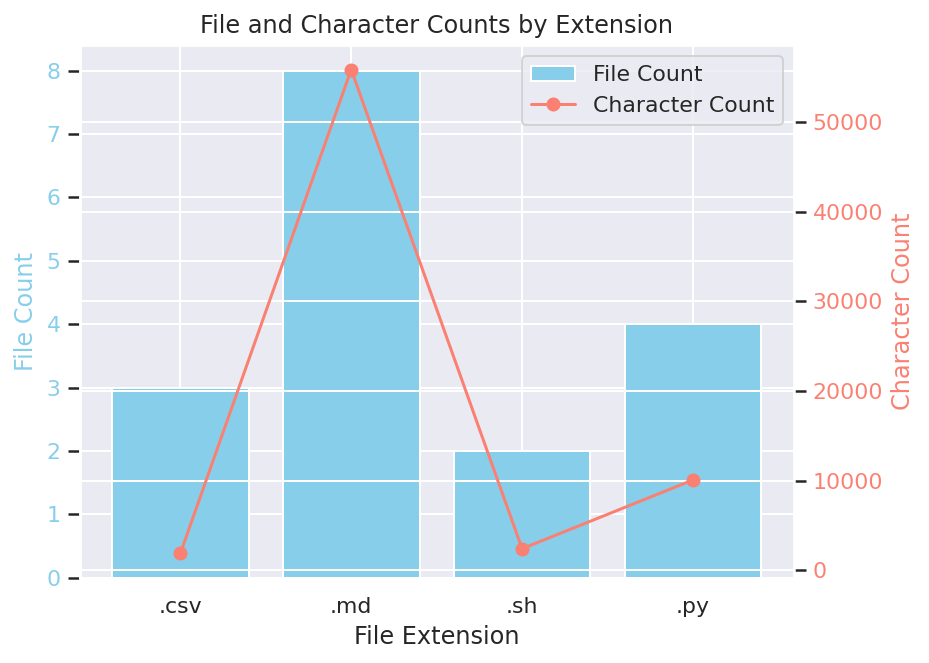

In [157]:
fig, ax1 = plt.subplots()

# Plotting File Count as bars
ax1.bar(df_counts['Extension'], df_counts['File Count'], color='skyblue', label='File Count')
ax1.set_xlabel('File Extension')
ax1.set_ylabel('File Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Creating a second y-axis for Character Count
ax2 = ax1.twinx()
ax2.plot(df_counts['Extension'], df_counts['Character Count'], color='salmon', marker='o', label='Character Count')
ax2.set_ylabel('Character Count', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Adding title and legends
plt.title('File and Character Counts by Extension')
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

# Training

In [158]:
# --- Global Charset Calculation ---
# Collect all characters from the entire dataset
all_chars = "".join([content for content in dataset if content is not None])
charset = sorted(list(set(all_chars)))
charset_size = len(charset)
char_to_idx = {char: idx for idx, char in enumerate(charset)}
# -----------------------------------

charset_size

151

In [159]:
def custom_collate_fn(batch, char_to_idx, charset_size, context_size=5):
    """
    Optimized custom collate function to handle variable-length text data for a bag-of-words approach.
    For each character in the text, the input is a vector mean of its surrounding context
    (excluding the character itself), and the target is the character's index.

    Args:
        batch (list): A list of text content strings from the dataset.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
        context_size (int): The number of characters to consider on each side of the target character.

    Returns:
        tuple: A tuple containing batched inputs and targets.
    """
    all_batched_inputs = []
    all_batched_targets = []

    # Process each content string in the batch
    for content in batch:
        if content is None:
            continue

        # Convert the entire content string to a list of numerical indices.
        # Characters not found in `char_to_idx` are mapped to -1, which will be ignored later.
        content_indices = [char_to_idx.get(char, -1) for char in content]

        inputs_for_content = []
        targets_for_content = []

        # Iterate through each character and its corresponding index in the content
        for i, target_idx in enumerate(content_indices):
            # Only process if the current target character is known (its index is not -1)
            if target_idx == -1:
                continue

            # --- Targets ---
            # For each valid character, we generate two (input, target) pairs:
            # 1. (Target Char One-Hot, Target Char Index) -> "Token --> Token"
            # 2. (Context Mean One-Hot, Target Char Index) -> "Context --> Token"

            # --- Input for "Token --> Token" ---
            # Create a one-hot vector for the target character itself.
            token_vector = torch.zeros(charset_size, dtype=torch.float)
            token_vector[target_idx] = 1
            inputs_for_content.append(token_vector)
            targets_for_content.append(torch.tensor(target_idx, dtype=torch.long))

            # --- Input for "Context --> Token" ---
            # This involves averaging one-hot vectors of characters in the surrounding context.

            # Define the boundaries of the context window.
            # `start_idx_context` ensures we don't go before the beginning of the string.
            # `end_idx_context` ensures we don't go beyond the end of the string.
            start_idx_context = max(0, i - context_size)
            end_idx_context = min(len(content_indices), i + context_size + 1)

            context_chars_indices = []
            for k in range(start_idx_context, end_idx_context):
                # The target character itself should not be part of its own context.
                if k == i:
                    continue
                char_in_context_idx = content_indices[k]
                # Only include known characters (not -1) in the context sum.
                if char_in_context_idx != -1:
                    context_chars_indices.append(char_in_context_idx)

            # If there are valid characters in the context, compute their mean one-hot vector.
            if context_chars_indices:
                # Convert the list of context character indices into a PyTorch tensor.
                context_indices_tensor = torch.tensor(context_chars_indices, dtype=torch.long)
                # Generate one-hot vectors for all context characters simultaneously,
                # then average them up along the first dimension to get the bag-of-words context vector.
                context_vector = torch.mean(
                    torch.nn.functional.one_hot(context_indices_tensor, num_classes=charset_size).float(),
                    dim=0
                ).float()

                inputs_for_content.append(context_vector)
                targets_for_content.append(torch.tensor(target_idx, dtype=torch.long))
            else:
                # If no valid context characters, the context vector remains all zeros.
                # Ignore this case
                pass

        # After processing all characters in the current content string, add its generated
        # inputs and targets to the overall batch lists.
        if inputs_for_content:
            all_batched_inputs.extend(inputs_for_content)
            all_batched_targets.extend(targets_for_content)

    # After processing all content strings in the batch, stack all collected inputs and targets
    # into single PyTorch tensors.
    if all_batched_inputs:
        return torch.stack(all_batched_inputs), torch.stack(all_batched_targets)
    else:
        # If no valid data was found across the entire batch, return empty tensors
        # with appropriate shapes and data types to prevent errors in downstream processing.
        return torch.empty(0, charset_size, dtype=torch.float), torch.empty(0, dtype=torch.long)

In [160]:
cross_entropy_loss_function = torch.nn.CrossEntropyLoss()

def vae_loss_function(reconstruction_x, x, mu, logvar):
    """
    Calculates the VAE loss, consisting of Reconstruction Loss and KL Divergence Loss.

    Args:
        reconstruction_x (torch.Tensor): The output from the decoder (logits).
        x (torch.Tensor): The original one-hot encoded input (target).
        mu (torch.Tensor): Mean vector from the encoder.
        logvar (torch.Tensor): Log-variance vector from the encoder.

    Returns:
        torch.Tensor: The total VAE loss.
    """
    # If your decoder output layer has no (softmax) activation, use this.
    BCE = cross_entropy_loss_function(reconstruction_x, x)

    # KL Divergence Loss:
    # -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    KL_Divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + 0.06 * KL_Divergence


In [161]:
def train_model(model, dataset, num_epochs, learning_rate, char_to_idx, charset_size, batch_size=32, context_size=5):
    """
    Helper function to train the CHV model using DataLoader and collate_fn,
    and record loss for each batch and epoch.

    Args:
        model (CHV): The CHV model to train.
        dataset (FileDataset): The dataset to train on.
        num_epochs (int): The number of training epochs.
        learning_rate (float): The learning rate for the optimizer.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
        batch_size (int): The batch size for the DataLoader.
        context_size (int): The number of characters to consider on each side of the target character.

    Returns:
        tuple: A tuple containing lists of batch losses and epoch losses.
    """
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = vae_loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: custom_collate_fn(batch, char_to_idx, charset_size, context_size))

    batch_losses = []
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs_batch, targets_batch in dataloader:
            if inputs_batch.numel() == 0: # Skip empty batches
                continue

            optimizer.zero_grad()
            outputs, mu, logvar = model(inputs_batch)
            loss = criterion(outputs, targets_batch, mu, logvar)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            total_loss += loss.item()
            num_batches += 1

            print(f"\rEpoch [{epoch+1}/{num_epochs}:{num_batches}:{inputs_batch.shape}], Loss: {loss.item():.4f}", end='')

        epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        epoch_losses.append(epoch_loss)
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}, Min Loss: {min(batch_losses[-num_batches:]):.4f}, Max Loss: {max(batch_losses[-num_batches:]):.4f}")

    return batch_losses, epoch_losses

In [162]:
vector_size = 6
model = VAECHV(charset_size, vector_size)

In [163]:
print(model)

VAECHV(
  (encoder_linear): Linear(in_features=151, out_features=13, bias=True)
  (encoder_activation): Tanh()
  (decoder_expansion): Linear(in_features=6, out_features=53, bias=True)
  (decoder_nonlinear): Tanh()
  (decoder_output): Linear(in_features=53, out_features=151, bias=True)
)


In [164]:
batch_losses_0, epoch_losses_0 = train_model(model, dataset, num_epochs=40, learning_rate=0.06, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=0)

Epoch [1/40:6:torch.Size([13495, 151])], Loss: 14.8682
Epoch [1/40] Average Loss: 12.1817, Min Loss: 5.1373, Max Loss: 28.3227
Epoch [2/40:6:torch.Size([5488, 151])], Loss: 7.5750
Epoch [2/40] Average Loss: 11.8354, Min Loss: 4.7844, Max Loss: 30.7391
Epoch [3/40:6:torch.Size([8050, 151])], Loss: 25.9276
Epoch [3/40] Average Loss: 12.2642, Min Loss: 4.0302, Max Loss: 25.9276
Epoch [4/40:6:torch.Size([26858, 151])], Loss: 16.2161
Epoch [4/40] Average Loss: 12.5008, Min Loss: 5.3444, Max Loss: 19.9371
Epoch [5/40:6:torch.Size([5013, 151])], Loss: 7.8029
Epoch [5/40] Average Loss: 9.5995, Min Loss: 5.7019, Max Loss: 16.5682
Epoch [6/40:6:torch.Size([26495, 151])], Loss: 11.1161
Epoch [6/40] Average Loss: 8.9264, Min Loss: 3.2844, Max Loss: 16.6542
Epoch [7/40:6:torch.Size([2394, 151])], Loss: 4.0639
Epoch [7/40] Average Loss: 6.1718, Min Loss: 2.8157, Max Loss: 18.9321
Epoch [8/40:6:torch.Size([2432, 151])], Loss: 2.9391
Epoch [8/40] Average Loss: 9.4283, Min Loss: 2.8720, Max Loss: 29.08

In [165]:
batch_losses_1_1, epoch_losses_1_1 = train_model(model, dataset, num_epochs=20, learning_rate=0.0006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=1)

Epoch [1/20:6:torch.Size([14724, 151])], Loss: 11.7308
Epoch [1/20] Average Loss: 11.3740, Min Loss: 9.9400, Max Loss: 12.1183
Epoch [2/20:6:torch.Size([17450, 151])], Loss: 9.1332
Epoch [2/20] Average Loss: 10.9428, Min Loss: 9.1332, Max Loss: 12.1745
Epoch [3/20:6:torch.Size([2038, 151])], Loss: 8.5679
Epoch [3/20] Average Loss: 10.2496, Min Loss: 8.5679, Max Loss: 11.5823
Epoch [4/20:6:torch.Size([18236, 151])], Loss: 11.0670
Epoch [4/20] Average Loss: 10.3949, Min Loss: 8.5331, Max Loss: 11.9588
Epoch [5/20:6:torch.Size([7830, 151])], Loss: 11.6066
Epoch [5/20] Average Loss: 10.3234, Min Loss: 8.7650, Max Loss: 11.6066
Epoch [6/20:6:torch.Size([12616, 151])], Loss: 11.4128
Epoch [6/20] Average Loss: 10.3285, Min Loss: 8.7156, Max Loss: 11.4128
Epoch [7/20:6:torch.Size([7124, 151])], Loss: 9.8490
Epoch [7/20] Average Loss: 10.1476, Min Loss: 8.7425, Max Loss: 11.0695
Epoch [8/20:6:torch.Size([2322, 151])], Loss: 8.4891
Epoch [8/20] Average Loss: 9.9200, Min Loss: 8.4891, Max Loss: 1

In [166]:
batch_losses_1_2, epoch_losses_1_2 = train_model(model, dataset, num_epochs=10, learning_rate=0.006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=1)

Epoch [1/10:6:torch.Size([6078, 151])], Loss: 8.4261
Epoch [1/10] Average Loss: 9.2015, Min Loss: 8.1474, Max Loss: 10.4871
Epoch [2/10:6:torch.Size([10976, 151])], Loss: 8.6248
Epoch [2/10] Average Loss: 8.6192, Min Loss: 7.5413, Max Loss: 9.7886
Epoch [3/10:6:torch.Size([16652, 151])], Loss: 6.8001
Epoch [3/10] Average Loss: 8.0540, Min Loss: 6.8001, Max Loss: 8.7736
Epoch [4/10:6:torch.Size([8548, 151])], Loss: 7.8654
Epoch [4/10] Average Loss: 7.2878, Min Loss: 6.3106, Max Loss: 8.2553
Epoch [5/10:6:torch.Size([17450, 151])], Loss: 5.9989
Epoch [5/10] Average Loss: 6.7924, Min Loss: 5.9989, Max Loss: 7.8810
Epoch [6/10:6:torch.Size([17450, 151])], Loss: 5.4805
Epoch [6/10] Average Loss: 6.4104, Min Loss: 5.4805, Max Loss: 7.2021
Epoch [7/10:6:torch.Size([18280, 151])], Loss: 5.0262
Epoch [7/10] Average Loss: 6.0548, Min Loss: 5.0262, Max Loss: 6.8643
Epoch [8/10:6:torch.Size([18280, 151])], Loss: 4.7906
Epoch [8/10] Average Loss: 5.5659, Min Loss: 4.7906, Max Loss: 6.7536
Epoch [9/

In [167]:
batch_losses_3, epoch_losses_3 = train_model(model, dataset, num_epochs=20, learning_rate=0.006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=3)

Epoch [1/20:6:torch.Size([11148, 151])], Loss: 4.8622
Epoch [1/20] Average Loss: 5.0104, Min Loss: 4.6435, Max Loss: 5.4298
Epoch [2/20:6:torch.Size([17158, 151])], Loss: 4.1646
Epoch [2/20] Average Loss: 4.8147, Min Loss: 4.1646, Max Loss: 5.4848
Epoch [3/20:6:torch.Size([4282, 151])], Loss: 4.4821
Epoch [3/20] Average Loss: 4.5281, Min Loss: 4.0809, Max Loss: 4.8625
Epoch [4/20:6:torch.Size([17158, 151])], Loss: 3.6716
Epoch [4/20] Average Loss: 4.4228, Min Loss: 3.6716, Max Loss: 4.9327
Epoch [5/20:6:torch.Size([4864, 151])], Loss: 3.7532
Epoch [5/20] Average Loss: 4.2577, Min Loss: 3.7532, Max Loss: 4.9032
Epoch [6/20:6:torch.Size([15134, 151])], Loss: 3.3006
Epoch [6/20] Average Loss: 3.9820, Min Loss: 3.3006, Max Loss: 4.5829
Epoch [7/20:6:torch.Size([67364, 151])], Loss: 4.2131
Epoch [7/20] Average Loss: 3.7962, Min Loss: 3.5498, Max Loss: 4.2131
Epoch [8/20:6:torch.Size([7806, 151])], Loss: 3.5744
Epoch [8/20] Average Loss: 3.6182, Min Loss: 3.2224, Max Loss: 4.0557
Epoch [9/20

In [168]:
batch_losses_6, epoch_losses_6 = train_model(model, dataset, num_epochs=10, learning_rate=0.0006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=6)

Epoch [1/10:6:torch.Size([23242, 151])], Loss: 3.8894
Epoch [1/10] Average Loss: 3.1064, Min Loss: 2.6743, Max Loss: 3.8894
Epoch [2/10:6:torch.Size([16216, 151])], Loss: 4.3058
Epoch [2/10] Average Loss: 3.1896, Min Loss: 2.6299, Max Loss: 4.3058
Epoch [3/10:6:torch.Size([22136, 151])], Loss: 2.7191
Epoch [3/10] Average Loss: 3.1538, Min Loss: 2.7191, Max Loss: 4.2790
Epoch [4/10:6:torch.Size([4542, 151])], Loss: 3.5744
Epoch [4/10] Average Loss: 3.1396, Min Loss: 2.8858, Max Loss: 3.5744
Epoch [5/10:6:torch.Size([11382, 151])], Loss: 2.9467
Epoch [5/10] Average Loss: 3.0494, Min Loss: 2.7654, Max Loss: 3.4728
Epoch [6/10:6:torch.Size([804, 151])], Loss: 3.6801
Epoch [6/10] Average Loss: 3.1860, Min Loss: 2.8715, Max Loss: 3.6801
Epoch [7/10:6:torch.Size([3834, 151])], Loss: 2.9229
Epoch [7/10] Average Loss: 3.1061, Min Loss: 2.9229, Max Loss: 3.7772
Epoch [8/10:6:torch.Size([66086, 151])], Loss: 2.8402
Epoch [8/10] Average Loss: 3.1527, Min Loss: 2.8402, Max Loss: 3.5096
Epoch [9/10:

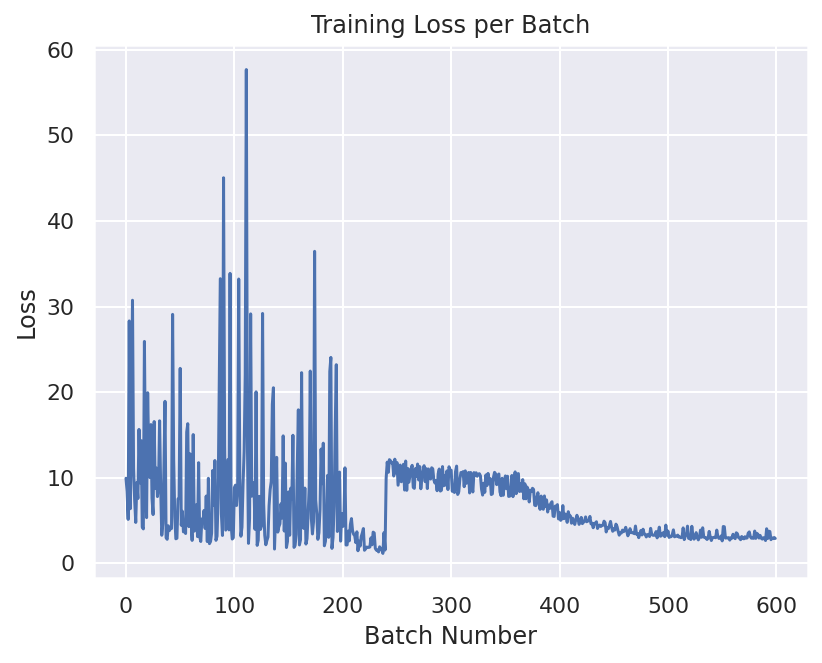

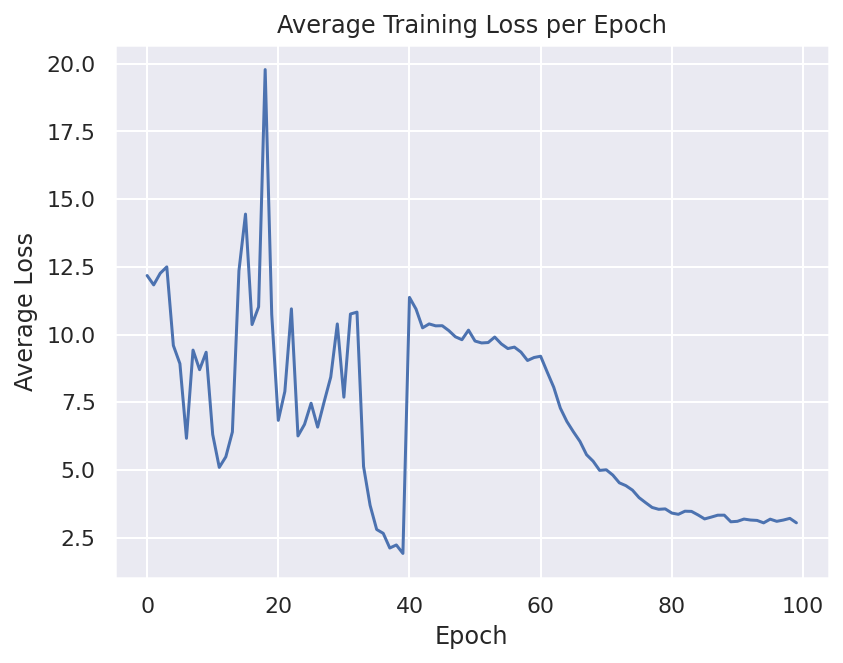

In [169]:
# Plotting batch losses
plt.figure()
plt.plot(batch_losses_0 + batch_losses_1_1 + batch_losses_1_2 + batch_losses_3 + batch_losses_6, label='Batch Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()

# Plotting epoch losses
plt.figure()
plt.plot(epoch_losses_0 + epoch_losses_1_1 + epoch_losses_1_2 + epoch_losses_3 + epoch_losses_6, label='Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Training Loss per Epoch')
plt.show()

# Model Testing

In [170]:
def test_model(model, sentence, char_to_idx, charset_size):
    """
    Tests the CHV model with a given sentence.

    Args:
        model (CHV): The trained CHV model.
        sentence (str): The input sentence for testing.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
    """
    model.eval() # Set the model to evaluation mode

    print(f"Input Sentence: '{sentence}'")
    print("\nCharacter Embeddings:")

    embeddings = []
    reconstructed_outputs = []
    reconstructed_chars = []

    idx_to_char = {idx: char for char, idx in char_to_idx.items()} # Create index to character mapping

    with torch.no_grad(): # Disable gradient calculation for inference
        softmax = torch.nn.Softmax(dim=-1) # For probabilistic output

        for char in sentence:
            if char in char_to_idx:
                # Create one-hot encoding for the character
                one_hot = torch.zeros(charset_size)
                one_hot[char_to_idx[char]] = 1
                input_tensor = one_hot.unsqueeze(0) # Add batch dimension

                # Get the embedding
                embedding = model.reparameterize(*model.encode(input_tensor)).squeeze(0)
                embeddings.append(embedding.numpy()) # Store as NumPy array

                # Get the reconstructed output (probabilities)
                reconstructed = softmax(model.decode(embedding.unsqueeze(0)))
                reconstructed_outputs.append(reconstructed.numpy()) # Store as NumPy array

                # Get the index of the most likely character
                predicted_idx = torch.argmax(reconstructed).item()
                reconstructed_char = idx_to_char.get(predicted_idx, '?') # Get character, use '?' for unknown
                reconstructed_chars.append(reconstructed_char)

                print(f"  Character '{char}': {embedding.tolist()}")
            else:
                print(f"  Character '{char}': Not in charset")
                reconstructed_chars.append('?') # Add '?' for unknown characters in reconstructed string

    print("\nEncode-Decode Output vs Original:")
    for i, char in enumerate(sentence):
        if char in char_to_idx:
            original_one_hot = torch.zeros(charset_size)
            original_one_hot[char_to_idx[char]] = 1
            original_output = original_one_hot.numpy()
            reconstructed_output = reconstructed_outputs[i]

            print(f"  Character '{char}':")
            print(f"    Original (One-Hot): {original_output.tolist()}")
            print(f"    Reconstructed (Probabilities): {reconstructed_output.tolist()}")
            print(f"    Reconstructed Character: '{reconstructed_chars[i]}'")

        else:
             print(f"  Character '{char}': Not in charset - Cannot compare")
             print(f"    Reconstructed Character: '{reconstructed_chars[i]}'")


    print(f"\nReconstructed Sentence: {''.join(reconstructed_chars)}")

In [171]:
test_model(model, 'Hello World! in Character Vector by Avaktrahu Shashthishalaka', char_to_idx, charset_size)

Input Sentence: 'Hello World! in Character Vector by Avaktrahu Shashthishalaka'

Character Embeddings:
  Character 'H': [-0.8120622038841248, -0.8118900060653687, -0.8108586668968201, -0.8112481236457825, -0.8107990622520447, -0.8117705583572388]
  Character 'e': [-0.08772651851177216, -0.08621381223201752, -0.0882195457816124, -0.08692999184131622, -0.08739376813173294, -0.08564933389425278]
  Character 'l': [-0.6930246353149414, -0.691472053527832, -0.6922060251235962, -0.6918075680732727, -0.6921901702880859, -0.6922661662101746]
  Character 'l': [-0.6930246353149414, -0.691472053527832, -0.6922060251235962, -0.6918075680732727, -0.6921901702880859, -0.6922661662101746]
  Character 'o': [0.045795343816280365, 0.04745250195264816, 0.04709889739751816, 0.046610355377197266, 0.04670357704162598, 0.04676312953233719]
  Character ' ': [0.9946509003639221, 0.9965735077857971, 0.9936306476593018, 0.9957369565963745, 0.9944978952407837, 0.9956862330436707]
  Character 'W': [-0.8723785877227

In [172]:
# Generate embeddings for all characters in the charset
all_char_embeddings = []
for char in charset:
    if char in char_to_idx:
        one_hot = torch.zeros(charset_size)
        one_hot[char_to_idx[char]] = 1
        input_tensor = one_hot.unsqueeze(0)
        embedding = model.reparameterize(*model.encode(input_tensor)).squeeze(0).detach().numpy() # Detach and convert to numpy
        all_char_embeddings.append(embedding)

# Convert embeddings to a pandas DataFrame for easier plotting
embeddings_df = pd.DataFrame(all_char_embeddings, index=charset)

embeddings_df.describe()

,0,1,2,3,4,5
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.267594,0.265715,0.268932,0.266835,0.267830,0.266485
std,0.513558,0.512725,0.514019,0.513161,0.513395,0.513278
min,-0.998675,-0.999519,-0.998801,-0.999552,-0.998987,-0.999856
25%,0.068298,0.067010,0.067567,0.067308,0.067347,0.066550
50%,0.472794,0.468323,0.473824,0.469693,0.472962,0.469201
75%,0.664551,0.661234,0.667968,0.664468,0.665728,0.663627
max,0.994651,0.996574,0.993631,0.995737,0.994498,0.995686


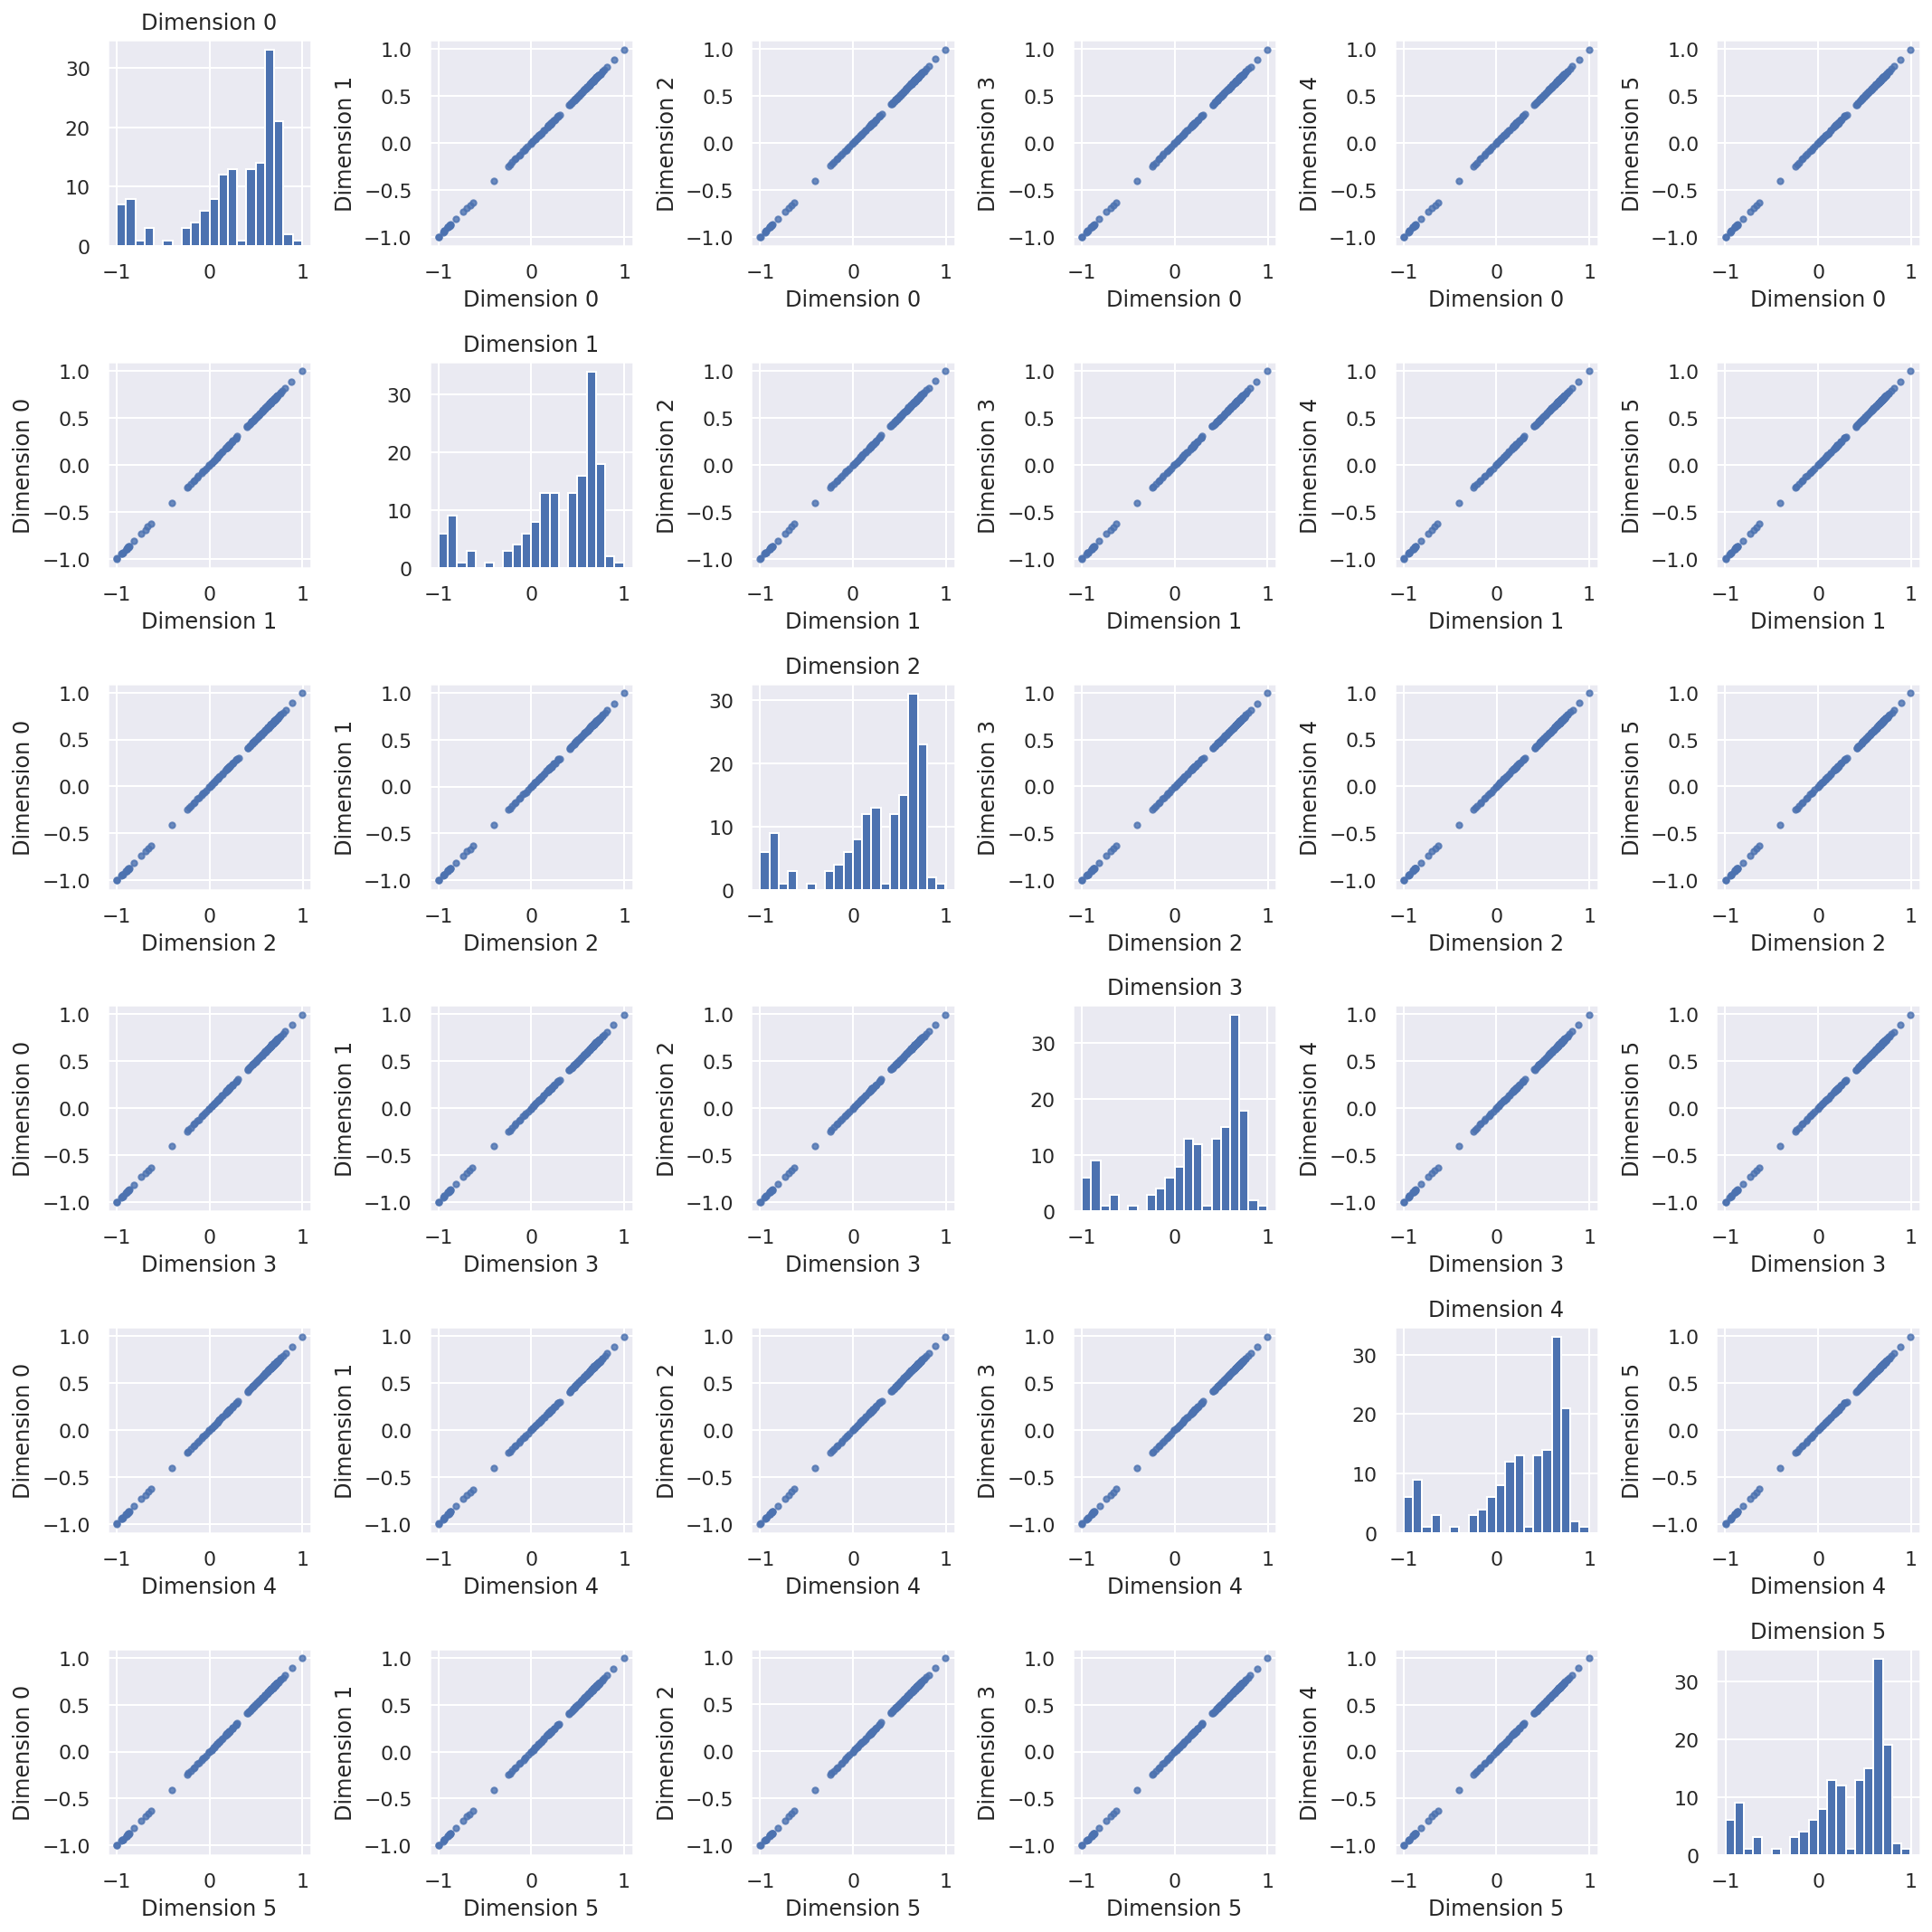

In [173]:
# Generate 2D scatter plots for all combinations of pairs of dimensions
num_dimensions = embeddings_df.shape[1]
fig, axes = plt.subplots(num_dimensions, num_dimensions, figsize=(15, 15))

for i in range(num_dimensions):
    for j in range(num_dimensions):
        if i == j:
            # Plot histogram on the diagonal
            embeddings_df[i].plot(kind='hist', bins=20, ax=axes[i, j])
            axes[i, j].set_title(f'Dimension {i}')
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')
        else:
            # Plot scatter plot for off-diagonal
            embeddings_df.plot(kind='scatter', x=i, y=j, s=10, alpha=.8, ax=axes[i, j])
            axes[i, j].set_xlabel(f'Dimension {i}')
            axes[i, j].set_ylabel(f'Dimension {j}')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3202 (\N{KANNADA SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3205 (\N{KANNADA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3206 (\N{KANNADA LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3207 (\N{KANNADA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-

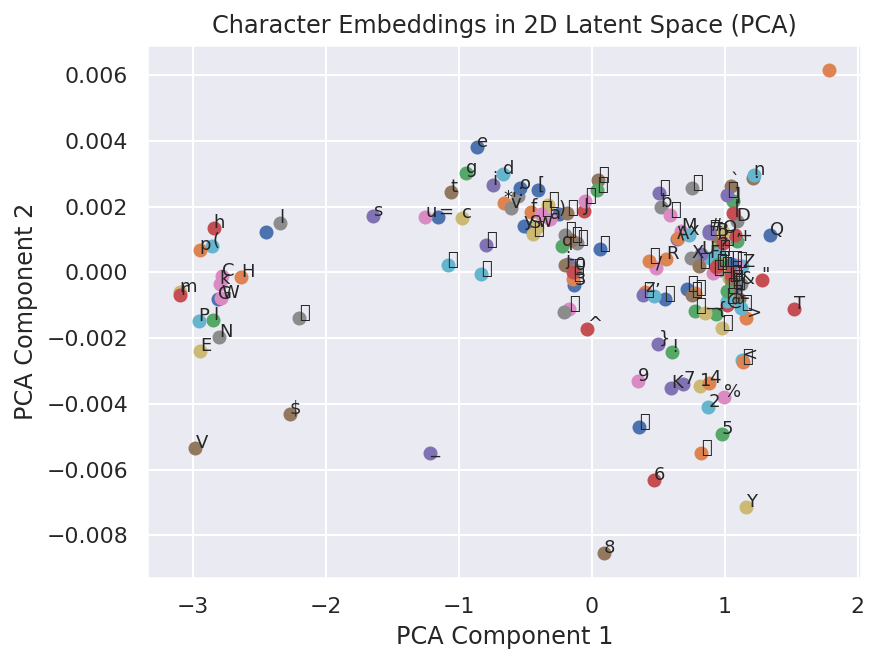

In [174]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(all_char_embeddings)

# Create a 2D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot each character
for i, char in enumerate(charset):
    ax.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o')
    ax.text(embeddings_2d[i, 0], embeddings_2d[i, 1], char, fontsize=9)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.title('Character Embeddings in 2D Latent Space (PCA)')

plt.show()

In [175]:
def evaluate_charset_reconstruction(model, charset, char_to_idx, charset_size):
    """
    Evaluates how well the model reconstructs each character in the charset using batch processing.

    Args:
        model (CHV): The trained CHV model.
        charset (list): The list of all characters in the charset.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.

    Returns:
        tuple: A tuple containing lists of original indices and predicted indices.
    """
    model.eval()  # Set the model to evaluation mode
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    softmax = torch.nn.Softmax(dim=-1)

    print("Evaluating Charset Reconstruction (Batched):")
    misreconstructed_chars = []
    original_indices = []
    predicted_indices = []

    with torch.no_grad():
        # Create a batch of one-hot encoded characters for the entire charset
        input_batch = torch.zeros(len(charset), charset_size)
        chars_in_batch = []


        for i, char in enumerate(charset):
            if char in char_to_idx:
                input_batch[i, char_to_idx[char]] = 1
                chars_in_batch.append(char)


        if input_batch.numel() == 0:
            print("No valid characters in the charset to evaluate.")
            return [], []

        # Get the embeddings and reconstructed outputs for the entire batch
        embeddings = model.reparameterize(*model.encode(input_batch)).squeeze(0)
        reconstructed_outputs = softmax(model.decode(embeddings))

        # Get the predicted indices for the batch
        predicted_indices_batch = torch.argmax(reconstructed_outputs, dim=1).tolist()

        # Collect original and predicted indices and identify misreconstructed characters
        for i, original_char in enumerate(chars_in_batch):
             original_idx = char_to_idx[original_char]
             predicted_idx = predicted_indices_batch[i]
             original_indices.append(original_idx)
             predicted_indices.append(predicted_idx)

             reconstructed_char = idx_to_char.get(predicted_idx, '?')
             if original_char != reconstructed_char:
                 misreconstructed_chars.append(f"'{original_char}' (encoded to '{reconstructed_char}')")


    if misreconstructed_chars:
        print("\nCharacters not reconstructed properly:")
        for char_pair in misreconstructed_chars:
            print(char_pair)
    else:
        print("\nAll characters in the charset were reconstructed properly.")

    return original_indices, predicted_indices

original_indices, predicted_indices = evaluate_charset_reconstruction(model, charset, char_to_idx, charset_size)

Evaluating Charset Reconstruction (Batched):

Characters not reconstructed properly:
'
' (encoded to 'r')
'!' (encoded to 'n')
'"' (encoded to ' ')
'#' (encoded to ' ')
'$' (encoded to 'r')
'%' (encoded to ' ')
'&' (encoded to ' ')
''' (encoded to 'o')
'(' (encoded to 'r')
')' (encoded to 'a')
'*' (encoded to 'i')
'+' (encoded to ' ')
',' (encoded to ' ')
'-' (encoded to 'a')
'.' (encoded to ' ')
'/' (encoded to 'n')
'0' (encoded to 'a')
'1' (encoded to ' ')
'2' (encoded to ' ')
'3' (encoded to 'a')
'4' (encoded to ' ')
'5' (encoded to ' ')
'6' (encoded to 'n')
'7' (encoded to 'n')
'8' (encoded to ' ')
'9' (encoded to 'n')
':' (encoded to 'o')
';' (encoded to ' ')
'<' (encoded to ' ')
'>' (encoded to ' ')
'?' (encoded to ' ')
'@' (encoded to ' ')
'A' (encoded to 'n')
'B' (encoded to ' ')
'C' (encoded to 'r')
'D' (encoded to ' ')
'E' (encoded to 'r')
'F' (encoded to ' ')
'G' (encoded to 'r')
'H' (encoded to 'r')
'I' (encoded to 'r')
'J' (encoded to 'a')
'K' (encoded to 'n')
'L' (encoded

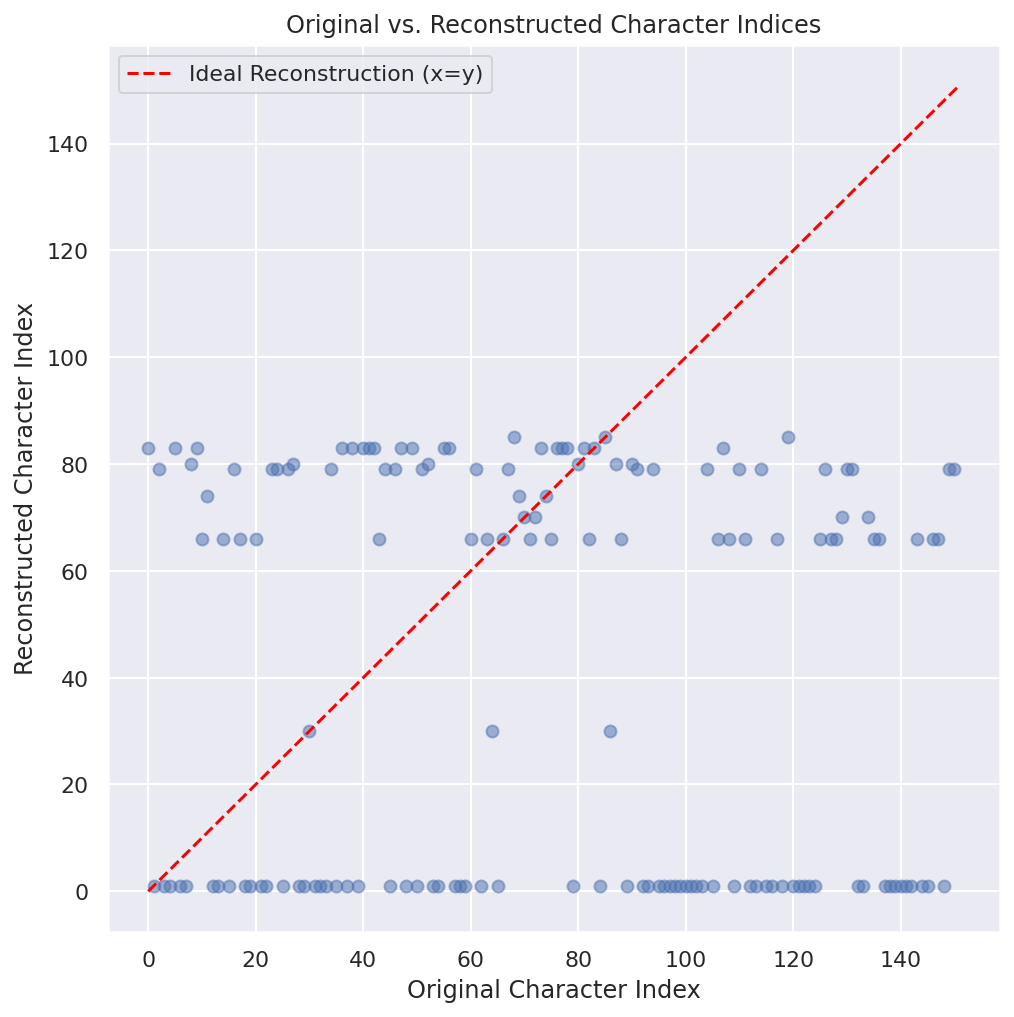

In [176]:
plt.figure(figsize=(8, 8))
plt.scatter(original_indices, predicted_indices, alpha=0.5)
plt.plot([0, charset_size], [0, charset_size], color='red', linestyle='--', label='Ideal Reconstruction (x=y)')
plt.xlabel('Original Character Index')
plt.ylabel('Reconstructed Character Index')
plt.title('Original vs. Reconstructed Character Indices')
plt.legend()
plt.grid(True)
plt.show()